In [1]:
import re  # Import regular expression library for text processing
import string  # Import string library to handle punctuation removal
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data into training and testing sets and hyperparameter tuning
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text into numerical features (TF-IDF representation)
from sklearn.linear_model import LogisticRegression  # Logistic Regression model for classification
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.svm import SVC  # Support Vector Classifier for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc  # Evaluation metrics for model performance
from imblearn.over_sampling import RandomOverSampler  # Used to handle class imbalance by oversampling the minority class
from imblearn.pipeline import Pipeline  # To create a pipeline that chains transformations and classifiers together
import seaborn as sns  # For visualization, especially confusion matrix heatmaps
import matplotlib.pyplot as plt  # For plotting visualizations like confusion matrix and ROC curve
from sklearn.preprocessing import LabelEncoder  # Encodes categorical target labels into numeric values
import nltk  # Natural language processing (NLP) library for text processing tasks
from nltk.stem import WordNetLemmatizer  # For lemmatizing words, reducing them to their base form
from nltk.corpus import stopwords  # To filter out common stopwords ('the', 'is') during preprocessing
import pandas as pd  # For data manipulation, reading CSV files, and handling datasets
import tkinter as tk  # GUI components for creating the user interface
from tkinter import messagebox  # For displaying message boxes in the GUI


In [2]:

# Ensures necessary NLTK resources are downloaded
nltk.download('punkt')  # Downloads tokenizer resources
nltk.download('stopwords')  # Downloads common stopwords list
nltk.download('wordnet')  # Downloads lemmatizer resources

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vella\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vella\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vella\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Sets a random seed 
random_state = 42

# Loads the dataset into a pandas DataFrame
df = pd.read_csv('reduced_dataset_20030228_from_unzipped.csv')  # Dataset containing email data

# Initializes the WordNetLemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()  # Lemmatizer reduces words to base forms (e.g., "running" to "run")
stop_words = set(stopwords.words('english'))  # Stopwords are common words to ignore during text processing

In [4]:
# Preprocessing function for cleaning email text
def preprocess_email(text, remove_punctuation=True, lowercase=True, remove_urls=True, remove_numbers=True, remove_headers=True):
    """
    Preprocesses the email text by:
    - Removing email headers (e.g., 'From', 'To', 'Subject')
    - Replacing numbers with the placeholder 'NUMBER'
    - Removing URLs
    - Converting text to lowercase
    - Removing punctuation
    - Lemmatizing words
    - Removing stopwords

    Args:
        text (str): The email text to preprocess.
        remove_punctuation (bool): Whether to remove punctuation.
        lowercase (bool): Whether to convert text to lowercase.
        remove_urls (bool): Whether to remove URLs.
        remove_numbers (bool): Whether to replace numbers with a placeholder.
        remove_headers (bool): Whether to remove email headers.

    Returns:
        str: Cleaned and preprocessed text.
    """
    if remove_headers:
        # Removes headers like 'From:', 'To:', 'Subject:', 'Date:'
        text = re.sub(r'^(From:|To:|Subject:|Date:)[^\n]*\n', '', text, flags=re.MULTILINE)

    if remove_numbers:
        # Replaces all numeric sequences with the word 'NUMBER'
        text = re.sub(r'\d+', 'NUMBER', text)

    if remove_urls:
        # Removes URLs (e.g., 'http://example.com')
        text = re.sub(r'http\S+|www\S+', 'URL', text)

    if lowercase:
        # Converts the entire text to lowercase
        text = text.lower()

    if remove_punctuation:
        # Removes punctuation using string translation
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizes, lemmatizes words, and removes stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Recombines words into a single string
    return ' '.join(words)



In [5]:
# Applies preprocessing to the 'subject' column of the dataset
df['cleaned_text'] = df['subject'].apply(preprocess_email)  # Creates a new column for cleaned text

# Encodes the target labels (spam/ham) as numerical values (0 for ham, 1 for spam)
le = LabelEncoder()  # Converts categorical labels to numeric values
df['label'] = le.fit_transform(df['class'])  # Maps 'ham' -> 0 and 'spam' -> 1
print(df['label']) # for debugging!

# Splits the dataset into features (X) and target labels (y)
X = df['cleaned_text']  # Text data after preprocessing
y = df['label']  # Encoded labels

# Splits the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Defines the pipelines for the  models
pipeline_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', binary=True, max_features=10000, ngram_range=(1, 3))),  # TF-IDF conversion
    ('oversample', RandomOverSampler(random_state=random_state)),  # Balance classes using oversampling
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))  # Logistic Regression classifier
])

pipeline_rf = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', binary=True, max_features=10000, ngram_range=(1, 3))),  # TF-IDF conversion
    ('oversample', RandomOverSampler(random_state=random_state)),  # Balances classes using oversampling
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=random_state))  # Random Forest classifier
])

pipeline_svc = Pipeline([
    ('vectorizer', TfidfVectorizer(
        stop_words='english',  # Automatically removes common English stopwords ("the", "is"), which often don't add meaningful information.
        binary=True,           # Represents the presence (1) or absence (0) of each term, rather than counting term frequencies.
        max_features=10000,    # Limits the vocabulary size to the top 10,000 most frequent terms, balancing computational efficiency and model performance.
        ngram_range=(1, 3)     # Considers unigrams (individual words), bigrams (two-word combinations), and trigrams (three-word combinations).
    )),
    ('oversample', RandomOverSampler(random_state=random_state)),  # Balance classes using oversampling
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=random_state))  # SVC classifier
])


0      1
1      1
2      0
3      1
4      0
      ..
795    0
796    0
797    0
798    1
799    0
Name: label, Length: 800, dtype: int64


In [6]:
# Defines a common parameter grid for all models to tune the TF-IDF vectorizer settings

param_grid = {

    # Max document frequency: Ignore very common words (appear in more than a certain percentage of documents)
    # If a word appears in a large portion of the documents (e.g., 75%, 85%, or 95%), it is likely to be less informative
    # and is excluded from the feature set.
    'vectorizer__max_df': [0.75, 0.85, 0.95],  # Values to test for the maximum document frequency threshold



    # Min document frequency: Include words that appear in at least these many documents
    # Words that appear too infrequently (e.g., in only 1 or 2 documents) are likely to be noise and are excluded.
    # 'min_df=1' allows words appearing at least once in the corpus, while 'min_df=2' excludes those that appear very rarely.
    'vectorizer__min_df': [1, 2],  # Values to test for the minimum document frequency threshold

    # N-gram range: This defines the range of n-grams (sequences of n words) to be considered.
    # (1, 1) = Unigrams (single words), (1, 2) = Unigrams and Bigrams (pairs of consecutive words), 
    # (1, 3) = Unigrams, Bigrams, and Trigrams (triplets of consecutive words).
    # Including n-grams allows the model to capture context and semantic meaning that individual words alone might miss.
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]  # Values to test for the n-gram range

}



In [7]:
# Extends the grid for each models

param_grid_lr = {**param_grid, 'classifier__C': [0.01, 0.1, 1, 10, 100]}  # Logistic Regression regularization
param_grid_rf = {**param_grid, 'classifier__n_estimators': [100, 200, 500], 'classifier__max_depth': [10, 20, 50]}  # RF trees & depth
param_grid_svc = {**param_grid, 'classifier__C': [0.01, 0.1, 1, 10, 100]}  # SVC regularization

# Performs GridSearchCV to tune hyperparameters for each model
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, verbose=1, n_jobs=-1)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, verbose=1, n_jobs=-1)
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=3, verbose=1, n_jobs=-1)

# Fits the models using the training data
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)

# Function for evaluating model performance
def evaluate_model(grid_search, X_test, y_test):
    """
    Evaluates the model using test data and returns metrics.
    """
    y_pred = grid_search.best_estimator_.predict(X_test)  # Predictions using the best model

    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy
    precision = precision_score(y_test, y_pred)  # Precision: True Positives / (True Positives + False Positives)
    recall = recall_score(y_test, y_pred)  # Recall: True Positives / (True Positives + False Negatives)
    f1 = f1_score(y_test, y_pred)  # F1 Score: Harmonic mean of precision and recall

    return accuracy, precision, recall, f1, y_pred

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 90 candidates, totalling 270 fits


In [8]:
# Visualizing the TF-IDF vectors as strings (in terminal)
def visualize_vectors(model, text_data):
    """
    Converts the given text data into its TF-IDF vectorized form and prints each vector as a string.
    
    Args:
        model (TfidfVectorizer): The trained TF-IDF vectorizer.
        text_data (list of str): The cleaned text data (e.g., emails).
    """
    tfidf_matrix = model.transform(text_data)  # Transforming text data into TF-IDF representation
    dense_matrix = tfidf_matrix.todense()  # Converting sparse matrix to dense format
    feature_names = model.get_feature_names_out()  # Getting feature names (terms)

    for i, text in enumerate(text_data):  # Loop through each email
        vector_string = []
        for j, value in enumerate(dense_matrix[i].tolist()[0]):  # Iterates over non-zero values
            if value > 0:  # Only printing non-zero values (important terms)
                vector_string.append(f"{feature_names[j]}:{value:.4f}")  # Formatting with 4 decimal places
        print(f"Text {i + 1} Vector: " + ", ".join(vector_string) + "\n")  # Adding newline after each vector


In [9]:
visualize_vectors(grid_search_lr.best_estimator_.named_steps['vectorizer'], X_train[:5])

# Evaluating and storing results for each model
results = {}
results['Logistic Regression'] = evaluate_model(grid_search_lr, X_test, y_test)
results['Random Forest'] = evaluate_model(grid_search_rf, X_test, y_test)
results['SVC'] = evaluate_model(grid_search_svc, X_test, y_test)


Text 1 Vector: free:0.2098, free porn:0.3143, free porn movie:0.3143, minute:0.2955, minute free:0.3143, minute free porn:0.3143, movie:0.2821, number:0.1479, number minute:0.2955, number minute free:0.3143, porn:0.2955, porn movie:0.3143

Text 2 Vector: adv:0.1930, adv rate:0.2709, adv rate slashed:0.2709, ccaxc:0.2709, dont:0.2208, dont wait:0.2709, dont wait ccaxc:0.2709, rate:0.1830, rate slashed:0.2709, rate slashed dont:0.2709, slashed:0.2709, slashed dont:0.2709, slashed dont wait:0.2709, wait:0.2709, wait ccaxc:0.2709

Text 3 Vector: company:0.2521, company hiring:0.2741, company hiring home:0.2741, fortune:0.2656, fortune number:0.2656, fortune number company:0.2741, hiring:0.2656, hiring home:0.2741, hiring home rep:0.2741, home:0.2227, home rep:0.2521, number:0.1492, number company:0.2741, number company hiring:0.2741, rep:0.2521

Text 4 Vector: best:0.2209, best price:0.2776, best replica:0.2776, best replica good:0.2776, good:0.2473, good best:0.2776, good best price:0.277

In [10]:
for model_name, result in results.items():
    print(f"\nClassification results for {model_name}:")
    y_pred = result[4]  # Extracts predictions
    print(classification_report(y_test, y_pred, target_names=le.classes_))



Classification results for Logistic Regression:
              precision    recall  f1-score   support

         ham       0.95      0.93      0.94        80
        spam       0.93      0.95      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160


Classification results for Random Forest:
              precision    recall  f1-score   support

         ham       0.92      0.76      0.84        80
        spam       0.80      0.94      0.86        80

    accuracy                           0.85       160
   macro avg       0.86      0.85      0.85       160
weighted avg       0.86      0.85      0.85       160


Classification results for SVC:
              precision    recall  f1-score   support

         ham       0.96      0.91      0.94        80
        spam       0.92      0.96      0.94        80

    accuracy                           0.94       160
   

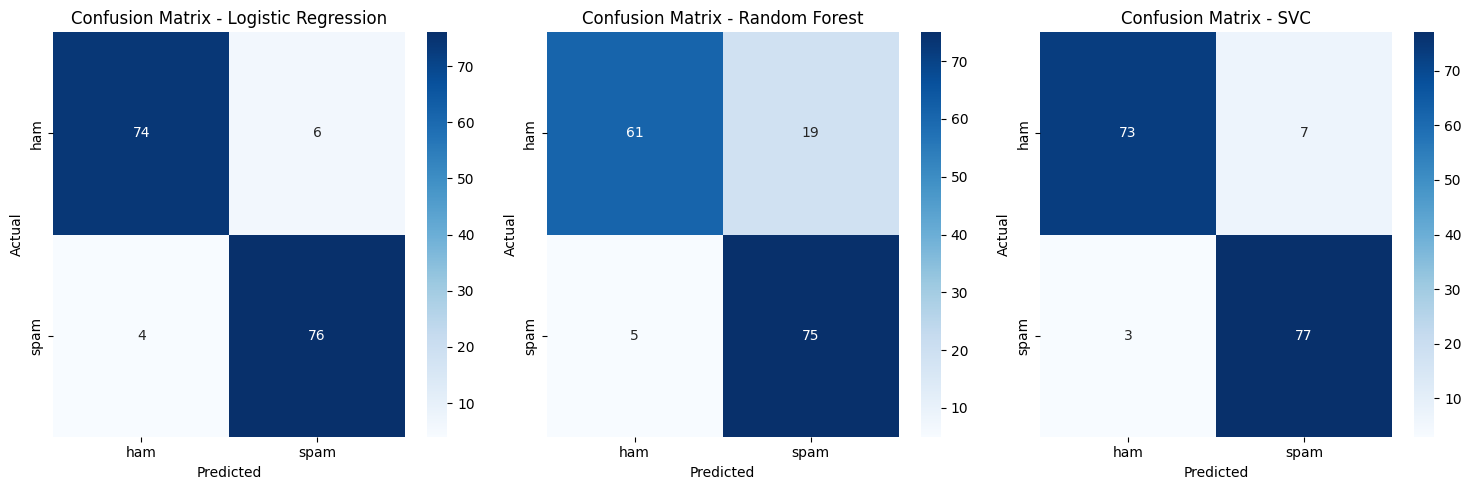

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [11]:
# Plots confusion matrices
plt.figure(figsize=(15, 5))
for i, (model_name, result) in enumerate(results.items(), 1):
    y_pred = result[4]
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plots ROC curves
plt.figure(figsize=(6, 5))

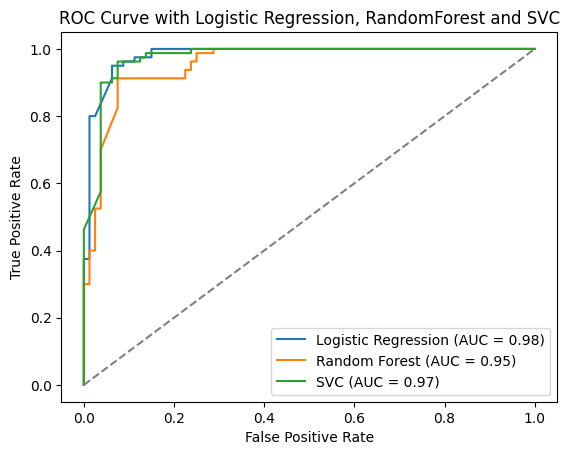

In [12]:

# Iterates over all models and plot their ROC curves
for model_name, result in results.items():
    # Gets predicted probabilities for each model
    if model_name == 'Logistic Regression':
        y_pred_prob = grid_search_lr.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of spam class
    elif model_name == 'Random Forest':
        y_pred_prob = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of spam class
    elif model_name == 'SVC':
        y_pred_prob = grid_search_svc.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of spam class

    # Calculates ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    # Plots ROC curve for the current model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plots diagonal line (random classifier line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Sets labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Logistic Regression, RandomForest and SVC')
plt.legend()


In [13]:
# Shows plot
plt.show()

# GUI for spam classification
def classify_message():

    """
    Classifies a user-entered message as spam or ham using the trained model.
    """

    message = message_entry.get()  # Gets the message entered by the user

    # Preprocesses the entered message
    message = preprocess_email(message)

    # Predicts the class using the Logistic Regression model (or another model of choice)
    prediction = grid_search_lr.best_estimator_.predict([message])

    # Maps the predicted class (0 or 1) back to 'ham' or 'spam'
    result = 'Spam' if prediction == 1 else 'Ham'

    # Shows the result in a message box
    messagebox.showinfo('Prediction Result', f'The message is classified as: {result}')


In [15]:
# Setting up the Tkinter window for the GUI
window = tk.Tk()
# Sets title and window size
window.title("Spam Classifier")
window.geometry("600x300")

# Setting up a label and entry box for the user to input a message
label = tk.Label(window, text='Enter your message:')
label.pack(pady=10)

message_entry = tk.Entry(window, width=80)  # Creating an entry field for input
message_entry.pack(pady=10)

# Button for triggering classification
button = tk.Button(window, text="Classify", command=classify_message)  # Button for triggering classification
button.pack(pady=20)

# Label for displaying the classification result (spam or ham)
result_label = tk.Label(window, text="", font=("Arial", 16), height=3)  # Displays result
result_label.pack(pady=10)

# Runs the GUI application
window.mainloop()  # Starts the Tkinter event loop